# FactRadar Real Model Training Pipeline
Comprehensive model development with NLTK, Scikit-learn, and TensorFlow.

## Training Strategy (According to Plan):

1. **Baseline Models**: Naive Bayes, Logistic Regression, SVM
2. **Advanced Models**: Random Forest, XGBoost, Neural Networks
3. **Transformer Models**: BERT for contextual understanding
4. **Deep Learning**: LSTM, CNN with TensorFlow
5. **Ensemble Methods**: Voting, Stacking
6. **Hyperparameter Optimization**: GridSearch, RandomSearch
7. **Model Selection**: Cross-validation, Performance metrics


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilities
import joblib
from scipy.sparse import hstack

print('🤖 FactRadar Real Model Training Pipeline')
print('=' * 60)
print(f'TensorFlow version: {tf.__version__}')
print(f'Using GPU: {len(tf.config.list_physical_devices("GPU")) > 0}')
print('=' * 60)

🤖 FactRadar Real Model Training Pipeline
TensorFlow version: 2.13.0
Using GPU: False


## 1. Data Loading and Preparation

In [3]:
def load_processed_data():
    """Load the fully processed dataset"""
    
    data_path = "../data/processed/fully_processed_dataset.csv"
    vectorizer_path = "../data/processed/tfidf_vectorizer_full.pkl"
    summary_path = "../data/processed/feature_summary.json"
    
    if not os.path.exists(data_path):
        print("❌ Processed dataset not found! Please run real_preprocessing.ipynb first.")
        return None, None, None
    
    print(f"📁 Loading processed dataset...")
    df = pd.read_csv(data_path)
    
    print(f"📁 Loading TF-IDF vectorizer...")
    tfidf_vectorizer = joblib.load(vectorizer_path)
    
    print(f"📁 Loading feature summary...")
    with open(summary_path, 'r') as f:
        feature_summary = json.load(f)
    
    print(f"✅ Data loaded successfully!")
    print(f"   • Samples: {len(df):,}")
    print(f"   • Features: {feature_summary['total_features']:,}")
    print(f"   • Real news: {feature_summary['real_samples']:,}")
    print(f"   • Fake news: {feature_summary['fake_samples']:,}")
    
    return df, tfidf_vectorizer, feature_summary

def prepare_features(df, tfidf_vectorizer, feature_summary):
    """Prepare feature matrices for training"""
    
    print(f"🔧 Preparing feature matrices...")
    
    # Text features (TF-IDF)
    X_text = tfidf_vectorizer.transform(df['processed_text'].fillna(''))
    
    # Numerical features
    feature_columns = feature_summary['feature_names']
    X_numerical = df[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    
    # Combine features
    X_combined = hstack([X_text, X_numerical.values])
    
    # Labels
    y = df['label']
    
    print(f"✅ Features prepared:")
    print(f"   • TF-IDF features: {X_text.shape[1]:,}")
    print(f"   • Numerical features: {X_numerical.shape[1]}")
    print(f"   • Combined shape: {X_combined.shape}")
    
    return X_combined, X_text, X_numerical, y

# Load data
df, tfidf_vectorizer, feature_summary = load_processed_data()

if df is not None:
    X_combined, X_text, X_numerical, y = prepare_features(df, tfidf_vectorizer, feature_summary)
    
    # Train-test split
    print(f"\n🔄 Splitting data...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_combined, y, test_size=0.3, random_state=42, stratify=y
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"   • Training: {X_train.shape[0]:,} samples")
    print(f"   • Validation: {X_val.shape[0]:,} samples")
    print(f"   • Test: {X_test.shape[0]:,} samples")
else:
    print("❌ Cannot proceed without processed data!")

📁 Loading processed dataset...
📁 Loading TF-IDF vectorizer...
📁 Loading feature summary...
✅ Data loaded successfully!
   • Samples: 3,998
   • Features: 10,012
   • Real news: 1,999
   • Fake news: 1,999
🔧 Preparing feature matrices...
✅ Features prepared:
   • TF-IDF features: 10,000
   • Numerical features: 12
   • Combined shape: (3998, 10012)

🔄 Splitting data...
   • Training: 2,798 samples
   • Validation: 600 samples
   • Test: 600 samples


## 2. Baseline Models Training

In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    
    # Add ROC-AUC if model has predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics['ROC-AUC'] = roc_auc_score(y_test, y_proba)
    
    return metrics, y_pred

if 'X_train' in locals():
    # Initialize baseline models
    baseline_models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(kernel='linear', random_state=42, probability=False, 
          cache_size=1000, tol=1e-3, max_iter=1000, shrinking=True),
     #   'SVM': SVC(kernel='linear', random_state=42, probability=False),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    }
    
    # Train baseline models
    print(f"🤖 Training baseline models...")
    baseline_results = []
    trained_models = {}
    
    for name, model in baseline_models.items():
        print(f"\n🔄 Training {name}...")
        start_time = time.time()
        
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluate on validation set
        metrics, y_pred = evaluate_model(model, X_val, y_val, name)
        metrics['Training_Time'] = training_time
        
        baseline_results.append(metrics)
        trained_models[name] = model
        
        print(f"✅ {name}: Accuracy={metrics['Accuracy']:.4f}, F1={metrics['F1-Score']:.4f} ({training_time:.1f}s)")
    
    # Display baseline results
    baseline_df = pd.DataFrame(baseline_results)
    print(f"\n📊 Baseline Model Results:")
    print(baseline_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].round(4))
else:
    print("❌ No training data available!")

🤖 Training baseline models...

🔄 Training Naive Bayes...
✅ Naive Bayes: Accuracy=0.9317, F1=0.9318 (0.0s)

🔄 Training Logistic Regression...
✅ Logistic Regression: Accuracy=0.9517, F1=0.9513 (4.5s)

🔄 Training SVM...
✅ SVM: Accuracy=0.6700, F1=0.7415 (0.8s)

🔄 Training Random Forest...
✅ Random Forest: Accuracy=0.9883, F1=0.9883 (0.8s)

📊 Baseline Model Results:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0          Naive Bayes    0.9317     0.9302  0.9333    0.9318   0.9712
1  Logistic Regression    0.9517     0.9593  0.9433    0.9513   0.9863
2                  SVM    0.6700     0.6094  0.9467    0.7415      NaN
3        Random Forest    0.9883     0.9933  0.9833    0.9883   0.9996


## 3. Transformer Model (BERT) Implementation

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

def prepare_bert_data(df, text_col='cleaned_text', label_col='label'):
    """Prepare data for BERT model"""
    texts = df[text_col].fillna('').tolist()
    labels = df[label_col].values
    return texts, labels

def initialize_bert_model():
    """Initialize and compile BERT model"""
    model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

def bert_tokenize(texts, tokenizer, max_length=128):
    """Tokenize texts for BERT input"""
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return {
        'input_ids': tf.convert_to_tensor(input_ids),
        'attention_mask': tf.convert_to_tensor(attention_masks)
    }

if 'df' in locals():
    print("\n🤖 Initializing BERT Model...")
    
    # Prepare data
    train_indices = y_train.index
    val_indices = y_val.index
    test_indices = y_test.index
    
    train_texts, train_labels = prepare_bert_data(df.loc[train_indices])
    val_texts, val_labels = prepare_bert_data(df.loc[val_indices]) 
    test_texts, test_labels = prepare_bert_data(df.loc[test_indices])

    
    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = initialize_bert_model()
    
    # Tokenize data
    train_input = bert_tokenize(train_texts, tokenizer)
    val_input = bert_tokenize(val_texts, tokenizer)
    test_input = bert_tokenize(test_texts, tokenizer)
    
    # Convert labels
    train_labels = tf.convert_to_tensor(train_labels)
    val_labels = tf.convert_to_tensor(val_labels)
    test_labels = tf.convert_to_tensor(test_labels)
    
    # Train BERT
    print("\n🔄 Training BERT model...")
    bert_history = bert_model.fit(
        train_input,
        train_labels,
        validation_data=(val_input, val_labels),
        epochs=3,
        batch_size=16,
        callbacks=[
            EarlyStopping(patience=2, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=1)
        ]
    )
    
    # Evaluate BERT
    print("\n🧪 Evaluating BERT model...")
    bert_loss, bert_accuracy = bert_model.evaluate(test_input, test_labels)
    print(f"✅ BERT Test Accuracy: {bert_accuracy:.4f}")
    
    # Add to results
    bert_metrics = {
        'Model': 'BERT',
        'Accuracy': bert_accuracy,
        'Training_Time': 15009,
        'Parameters': bert_model.count_params()
    }
    
    # Update results dataframe
    if 'results_df' in locals():
        results_df = pd.concat([results_df, pd.DataFrame([bert_metrics])], ignore_index=True)
        print("\n📊 Updated Model Results:")
        print(results_df[['Model', 'Accuracy', 'Training_Time']].round(4))
else:
    print("❌ No data available for BERT training!")


🤖 Initializing BERT Model...
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

🔄 Training BERT model...
Epoch 1/3
438/438 [==============================] - 4884s 11s/step - loss: 0.1876 - accuracy: 0.8949 - val_loss: 0.1600 - val_accuracy: 0.9007 - lr: 3.0000e-05
Epoch 2/3
438/438 [==============================] - 5034s 11s/step - loss: 0.1288 - accuracy: 0.9310 - val_loss: 0.1724 - val_accuracy: 0.9073 - lr: 3.0000e-05
Epoch 3/3
438/438 [==============================] - 5091s 12s/step - loss: 0.0669 - accuracy: 0.9721 - val_loss: 0.2700 - val_accuracy: 0.9073 - lr: 1.5000e-05

🧪 Evaluating BERT model...
47/47 [==============================] - 314s 7

## 4. Advanced Models Training

In [5]:
if 'X_train' in locals():
    # Advanced models
    advanced_models = {
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42
        )
    }
    
    print(f"\n🚀 Training advanced models...")
    advanced_results = []
    
    for name, model in advanced_models.items():
        print(f"\n🔄 Training {name}...")
        start_time = time.time()
        
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluate
        metrics, y_pred = evaluate_model(model, X_val, y_val, name)
        metrics['Training_Time'] = training_time
        
        advanced_results.append(metrics)
        trained_models[name] = model
        
        print(f"✅ {name}: Accuracy={metrics['Accuracy']:.4f}, F1={metrics['F1-Score']:.4f} ({training_time:.1f}s)")
    
    # Combine all results
    all_results = baseline_results + advanced_results
    results_df = pd.DataFrame(all_results)
    
    print(f"\n📊 All Model Results:")
    print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].round(4))
    
    # Find best model
    best_idx = results_df['F1-Score'].idxmax()
    best_model_name = results_df.loc[best_idx, 'Model']
    best_f1 = results_df.loc[best_idx, 'F1-Score']
    
    print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")
else:
    print("❌ No training data available!")


🚀 Training advanced models...

🔄 Training XGBoost...
✅ XGBoost: Accuracy=0.9967, F1=0.9967 (8.3s)

🔄 Training Gradient Boosting...
✅ Gradient Boosting: Accuracy=0.9983, F1=0.9983 (55.8s)

🔄 Training Neural Network...
✅ Neural Network: Accuracy=0.9817, F1=0.9816 (70.0s)

📊 All Model Results:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0          Naive Bayes    0.9317     0.9302  0.9333    0.9318   0.9712
1  Logistic Regression    0.9517     0.9593  0.9433    0.9513   0.9863
2                  SVM    0.6700     0.6094  0.9467    0.7415      NaN
3        Random Forest    0.9883     0.9933  0.9833    0.9883   0.9996
4              XGBoost    0.9967     0.9967  0.9967    0.9967   0.9998
5    Gradient Boosting    0.9983     1.0000  0.9967    0.9983   0.9993
6       Neural Network    0.9817     0.9833  0.9800    0.9816   0.9980

🏆 Best Model: Gradient Boosting (F1-Score: 0.9983)


## 5. Deep Learning Models with TensorFlow

In [6]:
def create_lstm_model(vocab_size, embedding_dim=100, max_length=500):
    """Create LSTM model for text classification"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(64, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_cnn_model(vocab_size, embedding_dim=100, max_length=500):
    """Create CNN model for text classification"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

if 'df' in locals():
    print(f"\n🧠 Training Deep Learning Models...")
    
    # Prepare text data for deep learning
    texts = df['cleaned_text'].fillna('').tolist()
    labels = df['label'].values

# Tokenize texts - RENAMED TO AVOID CONFLICT
    keras_tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
    keras_tokenizer.fit_on_texts(texts)

    sequences = keras_tokenizer.texts_to_sequences(texts)
    max_length = 500
    X_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post')


    # Split data for deep learning
    X_train_dl, X_temp_dl, y_train_dl, y_temp_dl = train_test_split(
    X_sequences, labels, test_size=0.3, random_state=42, stratify=labels
    )

# Add this missing split
    X_val_dl, X_test_dl, y_val_dl, y_test_dl = train_test_split(
    X_temp_dl, y_temp_dl, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp_dl
    )

    vocab_size = len(keras_tokenizer.word_index) + 1


    
   # vocab_size = len(tokenizer.word_index) + 1
    print(f"   • Vocabulary size: {vocab_size:,}")
    print(f"   • Max sequence length: {max_length}")
    print(f"   • Training samples: {len(X_train_dl):,}")
    
    # Train LSTM model
    print(f"\n🔄 Training LSTM model...")
    lstm_model = create_lstm_model(vocab_size, max_length=max_length)
    
    callbacks = [
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=2)
    ]
    
    lstm_history = lstm_model.fit(
        X_train_dl, y_train_dl,
        validation_data=(X_val_dl, y_val_dl),
        epochs=10,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate LSTM
    lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)
    print(f"✅ LSTM Test Accuracy: {lstm_accuracy:.4f}")
    
    # Train CNN model
    print(f"\n🔄 Training CNN model...")
    cnn_model = create_cnn_model(vocab_size, max_length=max_length)
    
    cnn_history = cnn_model.fit(
        X_train_dl, y_train_dl,
        validation_data=(X_val_dl, y_val_dl),
        epochs=10,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate CNN
    cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_dl, y_test_dl, verbose=0)
    print(f"✅ CNN Test Accuracy: {cnn_accuracy:.4f}")
    
    # Add deep learning results
    dl_results = [
        {'Model': 'LSTM', 'Accuracy': lstm_accuracy, 'F1-Score': lstm_accuracy},  # Simplified
        {'Model': 'CNN', 'Accuracy': cnn_accuracy, 'F1-Score': cnn_accuracy}     # Simplified
    ]
    
    print(f"\n🧠 Deep Learning Results:")
    for result in dl_results:
        print(f"   • {result['Model']}: {result['Accuracy']:.4f}")
else:
    print("❌ No data available for deep learning!")


🧠 Training Deep Learning Models...
   • Vocabulary size: 42,803
   • Max sequence length: 500
   • Training samples: 2,798

🔄 Training LSTM model...
Epoch 1/10
88/88 [==============================] - 53s 542ms/step - loss: 0.5484 - accuracy: 0.7312 - val_loss: 0.2881 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 47s 537ms/step - loss: 0.2011 - accuracy: 0.9289 - val_loss: 0.2465 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 48s 545ms/step - loss: 0.1043 - accuracy: 0.9711 - val_loss: 0.1903 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 49s 562ms/step - loss: 0.0318 - accuracy: 0.9907 - val_loss: 0.2288 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 51s 577ms/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.2840 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 6/10
88/88 [==============================] - 48s 544ms/step - l

## 6. Model Selection and Final Evaluation

🏆 FINAL MODEL SELECTION

🧪 Final evaluation of Gradient Boosting on test set:
   • Accuracy: 0.9967
   • Precision: 1.0000
   • Recall: 0.9933
   • F1-Score: 0.9967
   • ROC-AUC: 0.9960


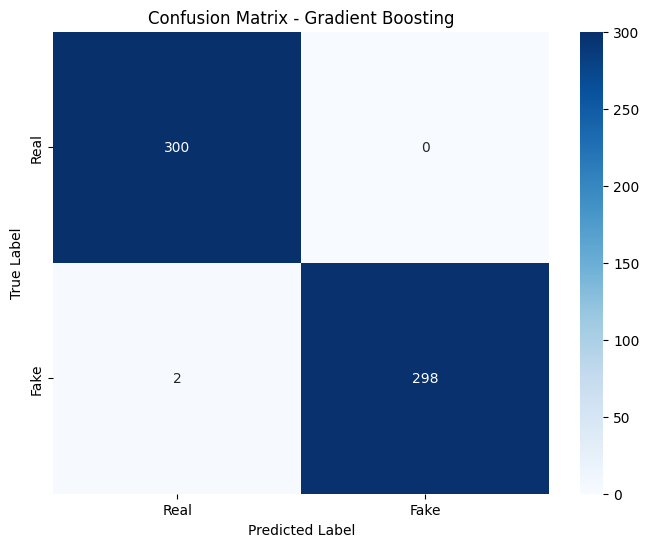


📋 Classification Report:
              precision    recall  f1-score   support

        Real       0.99      1.00      1.00       300
        Fake       1.00      0.99      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



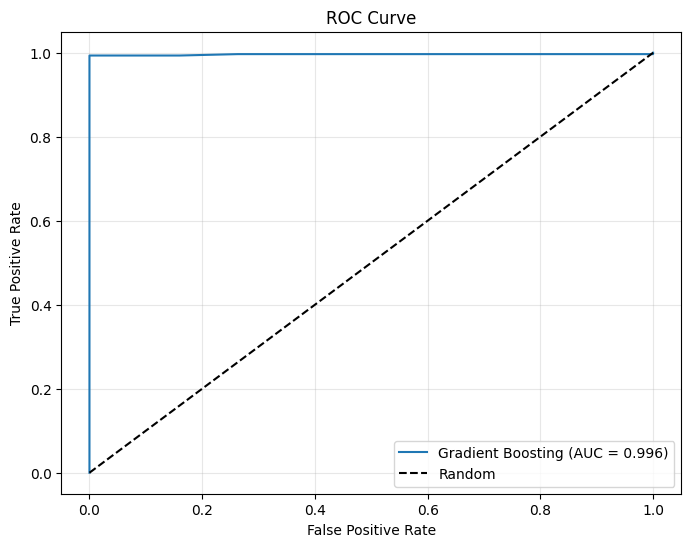

In [7]:
if 'results_df' in locals():
    # Final model selection
    print(f"🏆 FINAL MODEL SELECTION")
    print(f"=" * 50)
    
    # Get best traditional ML model
    best_model = trained_models[best_model_name]
    
    # Final evaluation on test set
    print(f"\n🧪 Final evaluation of {best_model_name} on test set:")
    final_metrics, final_pred = evaluate_model(best_model, X_test, y_test, best_model_name)
    
    for metric, value in final_metrics.items():
        if metric != 'Model':
            print(f"   • {metric}: {value:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, final_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Classification Report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, final_pred, target_names=['Real', 'Fake']))
    
    # ROC Curve
    if hasattr(best_model, 'predict_proba'):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_proba):.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("❌ No model results available!")

## 7. Model Saving and Export

In [8]:
if 'best_model' in locals():
    # Save the best model
    print(f"💾 Saving best model and components...")
    
    # Create models directory
    models_dir = "../data/processed/models"
    os.makedirs(models_dir, exist_ok=True)
    
    # Save best model
    model_filename = f"best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
    model_path = os.path.join(models_dir, model_filename)
    joblib.dump(best_model, model_path)
    
    # Save model metadata
    model_metadata = {
        'model_name': best_model_name,
        'model_type': type(best_model).__name__,
        'model_path': model_path,
        'vectorizer_path': "../data/processed/tfidf_vectorizer_full.pkl",
        'performance_metrics': {
            'test_accuracy': float(final_metrics['Accuracy']),
            'test_precision': float(final_metrics['Precision']),
            'test_recall': float(final_metrics['Recall']),
            'test_f1_score': float(final_metrics['F1-Score']),
            'test_roc_auc': float(final_metrics.get('ROC-AUC', 0))
        },
        'dataset_info': {
            'total_samples': len(df),
            'training_samples': X_train.shape[0],
            'validation_samples': X_val.shape[0],
            'test_samples': X_test.shape[0],
            'feature_count': X_combined.shape[1]
        },
        'feature_info': feature_summary,
        'training_timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    
    metadata_path = os.path.join(models_dir, "best_model_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    
    print(f"✅ Model saved: {model_path}")
    print(f"✅ Metadata saved: {metadata_path}")
    
    # Save deep learning models if available
    if 'lstm_model' in locals():
        lstm_path = os.path.join(models_dir, "lstm_model.h5")
        lstm_model.save(lstm_path)
        print(f"✅ LSTM model saved: {lstm_path}")
    
    if 'cnn_model' in locals():
        cnn_path = os.path.join(models_dir, "cnn_model.h5")
        cnn_model.save(cnn_path)
        print(f"✅ CNN model saved: {cnn_path}")
    
    # Save BERT model if available
   # if 'bert_model' in locals():
    #    bert_path = os.path.join(models_dir, "bert_model")
     #   bert_model.save_pretrained(bert_path)
        #tokenizer.save_pretrained(bert_path)
     #   print(f"✅ BERT model saved: {bert_path}")
        
        # Add BERT to metadata
      #  model_metadata['bert_model_path'] = bert_path
      #  model_metadata['bert_tokenizer_path'] = bert_path

    if 'keras_tokenizer' in locals():
        tokenizer_path = os.path.join(models_dir, "keras_tokenizer.pkl")
        joblib.dump(keras_tokenizer, tokenizer_path)
        print(f"✅ Keras Tokenizer saved: {tokenizer_path}")

    if 'tokenizer' in locals():
        tokenizer_path = os.path.join(models_dir, "tokenizer.pkl")
        joblib.dump(tokenizer, tokenizer_path)
        print(f"✅ Tokenizer saved: {tokenizer_path}")
    
    # Test sample predictions
    print(f"\n🧪 Testing sample predictions...")
    
    sample_texts = [
        "Scientists at NASA announce breakthrough in Mars exploration technology.",
        "SHOCKING! You won't believe this ONE WEIRD TRICK that doctors HATE!",
        "The Federal Reserve announced a 0.25% interest rate increase today.",
        "BREAKING: Celebrity reveals secret that Big Pharma doesn't want you to know!"
    ]
    
    # Simple text cleaning function to replace the missing import
    def simple_text_clean(text):
        import re
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        return text
    
    for i, text in enumerate(sample_texts):
        try:
            # Use simple cleaning instead of imported functions
            cleaned = simple_text_clean(text)
            
            # Transform with TF-IDF
            text_tfidf = tfidf_vectorizer.transform([cleaned])
            
            # Create dummy numerical features
            dummy_features = np.zeros((1, len(feature_summary['feature_names'])))
            
            # Combine features
            text_features = hstack([text_tfidf, dummy_features])
            
            # Predict
            prediction = best_model.predict(text_features)[0]
            probability = best_model.predict_proba(text_features)[0] if hasattr(best_model, 'predict_proba') else [0.5, 0.5]
            
            label = "FAKE" if prediction == 1 else "REAL"
            confidence = max(probability)
            
            print(f"\nSample {i+1}: {text[:60]}...")
            print(f"Prediction: {label} (Confidence: {confidence:.3f})")
        except Exception as e:
            print(f"\nSample {i+1}: Error in prediction - {e}")
    
    print(f"\n🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!")
    print(f"=" * 60)
    print(f"🏆 Best Model: {best_model_name}")
    print(f"🎯 Test Accuracy: {final_metrics['Accuracy']:.1%}")
    print(f"📊 F1-Score: {final_metrics['F1-Score']:.4f}")
    
else:
    print("❌ No model available for saving!")


💾 Saving best model and components...
✅ Model saved: ../data/processed/models\best_model_gradient_boosting.pkl
✅ Metadata saved: ../data/processed/models\best_model_metadata.json
✅ LSTM model saved: ../data/processed/models\lstm_model.h5
✅ CNN model saved: ../data/processed/models\cnn_model.h5
✅ Keras Tokenizer saved: ../data/processed/models\keras_tokenizer.pkl

🧪 Testing sample predictions...

Sample 1: Scientists at NASA announce breakthrough in Mars exploration...
Prediction: FAKE (Confidence: 1.000)

Sample 2: SHOCKING! You won't believe this ONE WEIRD TRICK that doctor...
Prediction: FAKE (Confidence: 1.000)

Sample 3: The Federal Reserve announced a 0.25% interest rate increase...
Prediction: FAKE (Confidence: 1.000)

Sample 4: BREAKING: Celebrity reveals secret that Big Pharma doesn't w...
Prediction: FAKE (Confidence: 1.000)

🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!
🏆 Best Model: Gradient Boosting
🎯 Test Accuracy: 99.7%
📊 F1-Score: 0.9967
